# Install Requirements

In [3]:
%pip install transformers datasets
%pip install torch
%pip install matplotlib
%pip install umap-learn numba==0.48.0
%pip install pandas matplotlib datashader bokeh holoviews colorcet scikit-image

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached numba-0.48.0.tar.gz (2.0 MB)
  Preparing metadata (setup.py) ... done
  Using cached llvmlite-0.31.0.tar.gz (110 kB)
  Preparing metadata (setup.py) ... done
  Using cached umap-learn-0.5.2.tar.gz (86 kB)
  Preparing metadata (setup.py) ... done
  Using cached umap-learn-0.5.1.tar.gz (80 kB)
  Preparing metadata (setup.py) ... done
  Using cached umap-learn-0.5.0.tar.gz (81 kB)
  Preparing metadata (setup.py) ... done
  Using cached umap_learn-0.4.6-py3-none-any.whl
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [755 lines of output]
      /private/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/pip-install-b54b1l73/numba_74062527af434b5b87c7310ce502fcfe/setup.py:98: DeprecationWarning:
      
        `

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load Language Model

In [5]:
#MODEL_NAME = "DTAI-KULeuven/robbertje-1-gb-non-shuffled" # NL MODEL TODO: is the model trained on lowercased data?

MODEL_NAME = "roberta-base"

#MODEL_NAME = "xlm-roberta-base" # cross-lingual mode (https://huggingface.co/xlm-roberta-base)


In [6]:
from transformers import RobertaModel, AutoTokenizer, RobertaPreTrainedModel, BertModel, GPT2Model, pipeline
from transformers.pipelines.feature_extraction import FeatureExtractionPipeline

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
#model = RobertaModel.from_pretrained(MODEL_NAME)

# FIXME: cannot use pipeline for extracting layers other than the last one
model: FeatureExtractionPipeline = pipeline('feature-extraction', model=MODEL_NAME, tokenizer=tokenizer)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Load Data

In [7]:
from pathlib import Path

DATA_DIR = Path.cwd() / "data"

## SemEval 2020 (C)COHA corpus

### Download

In [8]:
from io import BytesIO
from zipfile import ZipFile
import urllib

SEMEVAL_DATA_URL = "https://www2.ims.uni-stuttgart.de/data/sem-eval-ulscd/semeval2020_ulscd_eng.zip"

SEMEVAL2020_DIR = DATA_DIR / "semeval2020_ulscd_eng"

if SEMEVAL2020_DIR.is_dir():
    print(f"Directory '{SEMEVAL2020_DIR}' already exists, skipping corpus download.")
else:
    with urllib.request.urlopen(SEMEVAL_DATA_URL) as f:
        with ZipFile(BytesIO(f.read())) as zipfile:
            zipfile.extractall(DATA_DIR)

assert SEMEVAL2020_DIR.is_dir(), f"Directory does not exist: '{SEMEVAL2020_DIR}'"


Directory '/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/ContextualLM/data/semeval2020_ulscd_eng' already exists, skipping corpus download.


In [9]:
CORPUS1_DIR = SEMEVAL2020_DIR / 'corpus1'
CORPUS2_DIR = SEMEVAL2020_DIR / 'corpus2'
TRUTH_DIR = SEMEVAL2020_DIR / 'truth'

assert CORPUS1_DIR.is_dir(), f"Directory does not exist: '{CORPUS1_DIR}'"
assert CORPUS2_DIR.is_dir(), f"Directory does not exist: '{CORPUS2_DIR}'"
assert TRUTH_DIR.is_dir(), f"Directory does not exist: '{TRUTH_DIR}'"


### Read

In [10]:
TOKENS_FILE1 = CORPUS1_DIR / "token" / "ccoha1.txt.gz"
TOKENS_FILE2 = CORPUS2_DIR / "token" / "ccoha2.txt.gz"

assert TOKENS_FILE1.is_file()
assert TOKENS_FILE2.is_file()

In [11]:
import gzip

with gzip.open(TOKENS_FILE1, 'rt') as f:
    sentences_1810 = f.readlines()

assert len(sentences_1810) == 253644

with gzip.open(TOKENS_FILE2, 'rt') as f:
    sentences_1960 = f.readlines()

assert len(sentences_1960) == 353692

## COHA Corpus (Sample)

### Download

In [12]:
#COHA_DATABASE_URL = 'https://www.corpusdata.org/coha/samples/database.zip'
COHA_TEXT_URL = 'https://www.corpusdata.org/coha/samples/text.zip'

COHA_DIR = DATA_DIR / "COHA"

try:
    COHA_DIR.mkdir(parents=True, exist_ok=False)
except OSError as e:
    print(f"Directory '{COHA_DIR}' already exists: {str(e)}. Skipping corpus download.")
else:
    with urllib.request.urlopen(COHA_TEXT_URL) as f:
        with ZipFile(BytesIO(f.read())) as zipfile:
            zipfile.extractall(COHA_DIR)

assert COHA_DIR.is_dir()

Directory '/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/ContextualLM/data/COHA' already exists: [Errno 17] File exists: '/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/ContextualLM/data/COHA'. Skipping corpus download.


### Read CohaDocs

In [13]:
from functools import cached_property
import logging
import re
from typing import Generator, List

FILENAME_PATTERN = r"([a-z]{2,4})_(\d{4})_(\d{3,6})\.txt"
SENTENCE_PATTERN = r"\s*(.*?\s[\.!?\n])"

class CohaDoc:
    _encoding = 'UTF-8'

    def __init__(self, path: Path):
        self._path = path

        try:
            genre, year, id = re.search(FILENAME_PATTERN, self._path.name).groups()
        except AttributeError as e:
            raise ValueError(f"Could not parse path: '{path}': {str(e)}")
        
        self._genre = genre
        self._year = int(year)
        self._id = int(id)

    def __repr__(self) -> str:
        return str(self._path.name)

    def __str__(self) -> str:
        return str(self._path.name)

    @property
    def genre(self) -> str:
        return self._genre

    @property
    def year(self) -> int:
        return self._year

    @property
    def id(self) -> int:
        return self._id
    
    @cached_property
    def text(self):
        with open(self._path, 'rt', encoding=self._encoding) as f:
            return f.read()

    def sentences(self):
        sentences = re.findall(SENTENCE_PATTERN, self.text)
        assert sentences[0].strip() == f"@@{self._id}", f"First line is expected to match document ID ('{self._id}'), but is: {sentences[0]}"
        return sentences[1:]

    def find_sentences(self, term: str) -> List[str]:
        """Find the sentences containing the term. No tokenization done, just string search."""
        return [
            sentence
            for sentence in self.sentences()
            if term in sentence
        ]
        
    def clean_sentences(self):
        # TODO
        return NotImplemented


In [14]:
coha_docs = [CohaDoc(file) for file in COHA_DIR.glob('*.txt')]

assert len(coha_docs) == 1144

(array([ 12.,  13.,  24.,  50.,  60., 156., 206., 188., 247., 188.]),
 array([1817. , 1836.2, 1855.4, 1874.6, 1893.8, 1913. , 1932.2, 1951.4,
        1970.6, 1989.8, 2009. ]),
 <BarContainer object of 10 artists>)

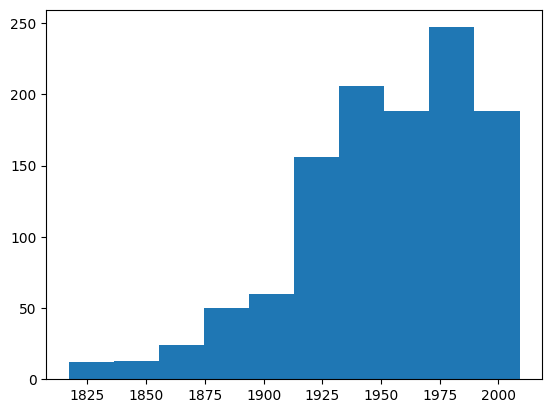

In [15]:
plt.hist([c.year for c in coha_docs])

(array([586.,   0.,   0., 424.,   0.,   0., 108.,   0.,   0.,  26.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

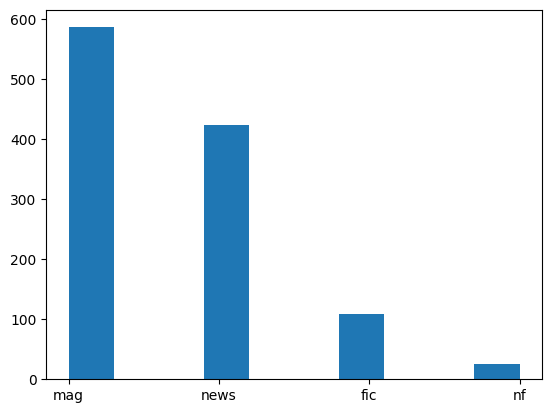

In [16]:
plt.hist([c.genre for c in coha_docs])

# Embeddings

In [125]:
TERM = 'organic'

## Find Relevant Sentences

In [126]:
import collections
from dataclasses import dataclass
from functools import cache
from itertools import islice
from typing import Iterable, List, Optional, Tuple
from transformers.pipelines.feature_extraction import FeatureExtractionPipeline
from numpy.typing import ArrayLike

def sliding_window(iterable, n):
    # From https://docs.python.org/3/library/itertools.html#itertools-recipes
    # sliding_window('ABCDEFG', 4) --> ABCD BCDE CDEF DEFG
    it = iter(iterable)
    window = collections.deque(islice(it, n), maxlen=n)
    if len(window) == n:
        yield tuple(window)
    for x in it:
        window.append(x)
        yield tuple(window)


@dataclass
class Sentence:
    text: str
    coha_doc: CohaDoc
    model: FeatureExtractionPipeline

    def __contains__(self, s: str):
        return s in self.text

    @property
    def year(self) -> Optional[int]:
        return self.coha_doc.year

    @property
    def tokenizer(self):
        return self.model.tokenizer

    @cached_property
    def _embeddings(self):
        return self.model(self.text)[0]

    @cached_property
    def _token_ids(self):
        return self.tokenizer(self.text)['input_ids']

    def embeddings_matrix(self, token: str) -> List[ArrayLike]:
        return [
                self._aggregate_embeddings(token_i, token_length)
                for token_i, token_length in self._find_token(token, self._token_ids)
            ]

    @staticmethod    
    def _find_token(token: str, token_ids: List[int], max_n: int = 5) -> Tuple[int, int]:
        """
        Find sequences of (sub-word) tokens that match a (word) token if merged

        Args:
            - token: a token (word) to find, exact match
            - token_ids: a sequence of token ids generated by a transformer tokenizer
            - max_n: the maximum number of sub-word tokens to be merged
        Yields: Tuple[int, int]: the token index and the length (number of tokens to be merged)
        """
        _tokens = model.tokenizer.convert_ids_to_tokens(token_ids)

        for n in range(max_n):
            for i, window in enumerate(sliding_window(_tokens, n)):
                _token = model.tokenizer.convert_tokens_to_string(window)
                if _token.strip() == token:
                    yield i, n

    def _aggregate_embeddings(self, token_start_index: int, n_tokens: int) -> ArrayLike:
        """Return a one-dimensional array of the (aggregated) token embedding(s).
        
        Args:
            - token_start_index: the token position in the sentence, according to the model's tokenizer
            - n_tokens: the number of tokens to aggregate (1 for a single token)
        
        Returns:
            A vector of shape (<embedding dimensionlaity, 1)
            for the token embedding at the given position, or the mean of multiple token embeddings
        """
        a: np.array
        if n_tokens == 1:
            a = np.array(self._embeddings[token_start_index])
        else:
            a = np.array(self._embeddings[token_start_index:token_start_index+n_tokens]).mean(axis=0)
        assert a.shape == (model.model.config.hidden_size, ), f"Invalid shape: {a.shape} for token index {token_start_index}, token length {n_tokens}."
        return a
        



In [127]:
from tqdm import tqdm

# TODO: this could be a generator
sentence_candidates: List[Sentence] = [
    Sentence(s, doc, model)
    for doc in tqdm(coha_docs, unit='doc')
    for s in doc.find_sentences(TERM)
]

print(len(sentence_candidates))

100%|██████████| 1144/1144 [00:00<00:00, 1265.73doc/s]

77


## Compute Embeddings

In [128]:
embeddings = [] # Changed into array below for efficiency
sentences = []

for sentence in tqdm(sentence_candidates, unit='sentence', desc=f"Embeddings for '{TERM}'"):
    for embedding in sentence.embeddings_matrix(TERM):
        embeddings.append(embedding)
        sentences.append(sentence)

assert len(embeddings) == len(sentences)
len(embeddings)

Embeddings for 'organic': 100%|██████████| 77/77 [00:18<00:00,  4.09sentence/s]


85

In [129]:
embeddings = np.array(embeddings)

assert embeddings.shape == (len(sentences), model.model.config.hidden_size), f"Shape {embeddings.shape} does not match expected shape {(len(sentences), model.model.config.hidden_size)}"
embeddings.shape

(85, 768)

In [130]:
sentences[0]

Sentence(text='" I \'m into organic foods and brought a batch with me .', coha_doc=fic_1979_10650.txt, model=<transformers.pipelines.feature_extraction.FeatureExtractionPipeline object at 0x7fe393c2ff10>)

## Plot PCA

In [131]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=2).fit_transform(embeddings)

Text(0.5, 1.0, "PCA Embeddings projections for 'organic'")

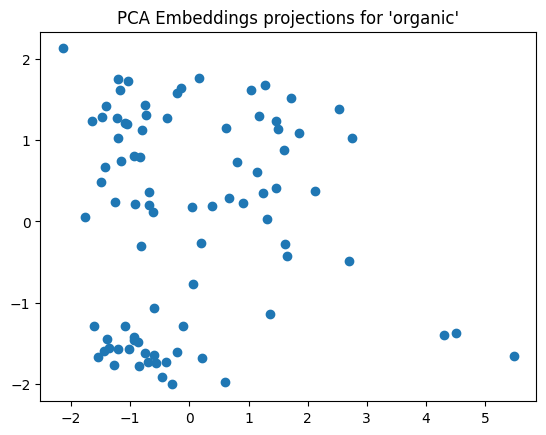

In [132]:
plt.scatter(X_pca[:,0], X_pca[:,1], label=TERM)
plt.title(f"PCA Embeddings projections for '{TERM}'")

## Plot UMAP

In [133]:
def get_decade(sentence: Sentence) -> str:
    start = int(sentence.coha_doc.year / 10) * 10
    end = start + 10
    return f"{start} - {end}"

hover_data = pd.DataFrame(data = {
        'doc': [sentence.coha_doc._path.name for sentence in sentences],
        'text': [sentence.text for sentence in sentences],
        'year': [sentence.coha_doc.year for sentence in sentences],
        'decade': [get_decade(sentence) for sentence in sentences],
    }
)

# TOOD: add match index for each sentence

assert len(hover_data) == len(embeddings), f"Number of embeddings ({len(embeddings)}) must equal number of sentence data points ({len(hover_data)})."
hover_data


,doc,text,year,decade
0,fic_1979_10650.txt,""" I 'm into organic foods and brought a batch ...",1979,1970 - 1980
1,mag_1891_572250.txt,"Life , liberty , and the pursuit of happiness ...",1891,1890 - 1900
2,mag_1923_467550.txt,That is the organic matter in which later the ...,1923,1920 - 1930
3,mag_1863_507550.txt,We have not named among the hypotheses from wh...,1863,1860 - 1870
4,mag_2007_389750.txt,"Kentucky farms produce flowers , garlic , orga...",2007,2000 - 2010
...,...,...,...,...
80,mag_1987_432350.txt,""" So far our soil tests indicate an average lo...",1987,1980 - 1990
81,nf_1896_750650.txt,"The convention was organized early in 1864 , a...",1896,1890 - 1900
82,nf_1896_750650.txt,"The danger in such departures , even upon appa...",1896,1890 - 1900
83,mag_2005_377150.txt,""" I do n't think natural and organic food is a...",2005,2000 - 2010


In [134]:
import umap
mapper = umap.UMAP().fit(embeddings)

In [135]:
import umap.plot

umap.plot.output_notebook()

title = f"UMAP Embeddings Projections for '{TERM}'"

Loading BokehJS ...

### Points

Text(0.5, 1.0, "UMAP Embeddings Projections for 'organic'")

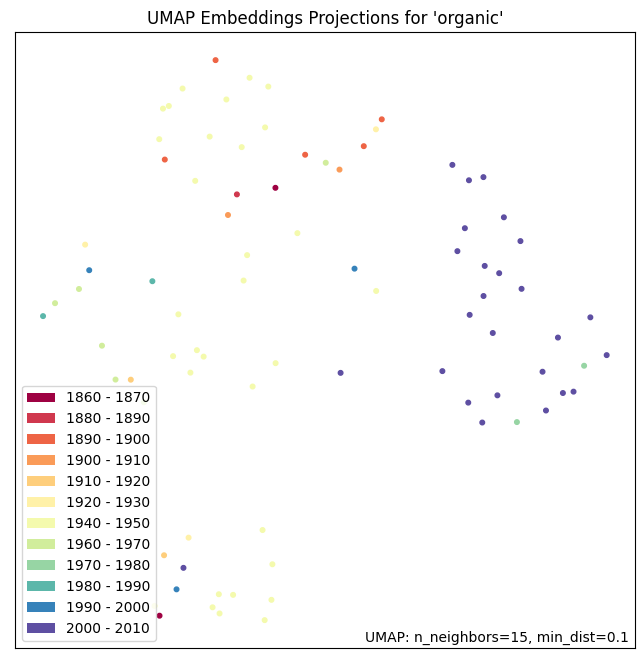

In [136]:
subplot = umap.plot.points(mapper, labels = hover_data['decade'])
subplot.set_title(title)


### Interactive

In [137]:

p = umap.plot.interactive(mapper, labels = hover_data['decade'], hover_data=hover_data)

p.title.text = title
umap.plot.show(p)


### Using Bokeh

In [138]:
from bokeh.models import ColumnDataSource

cds = ColumnDataSource(data={
        'x': mapper.embedding_[:,0],
        'y': mapper.embedding_[:,1],
    } | hover_data.to_dict('list')
)

cds

ColumnDataSource(id='7311', ...)

In [139]:
from bokeh.palettes import d3
from bokeh.models import CategoricalColorMapper
import bokeh.palettes

palette = bokeh.palettes.Paired12
categories = hover_data.decade.unique()

assert len(palette) >= len(categories)

color_mapper = CategoricalColorMapper(factors=categories, palette=palette)
color_mapper

CategoricalColorMapper(id='7316', ...)

In [141]:
from bokeh.plotting import figure, show

p = figure(tooltips=[('doc', '@doc'), ('text', '@text'), ('year', '@year')])

# TODO: group by decade to enable muting individually via legend
p.dot(
    x='x', y='y', legend_field = 'decade', source=cds,
    size=20,
    color={'field': 'decade', 'transform': color_mapper}
)

p.legend.click_policy="mute"

show(p)